In this kernel,We will go through all the basic steps to build a image segmentation model.For that,we will use many excellent peices of codes written by my fellow kagglers.I personally thank them for sharing their work so that the kaggle community could use it for betterment and gaining knowledge.

**We will go through :**
- Basic EDA
- Utility functions
- Data generators
- Building our Unet model
- Evaluation of our model.

![](https://media.giphy.com/media/UH75adh6PUj16/giphy.gif)

#### Also please do an upvote ^ if you like my work.I will be always thankful for your appreciation which motivates me to contribute further to this community.

## Importing whatever we need...

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import gc
import os
from pathlib import Path
import matplotlib.pyplot as plt
import keras
import cv2
from collections import defaultdict
from skimage.data import imread
from sklearn.model_selection import train_test_split
from keras import backend as K


path=Path('../input/understanding_cloud_organization')
os.listdir(path)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']

In [3]:
### Reading files
train=pd.read_csv(path/'train.csv')
train.shape

(22184, 2)

## Basic EDA

Before starting with Image segmentation,we will have a basic understanding about the data.This is essential to get good understanding about the problem.
- We will look at the class distribution.
- The number of masked and unmasked samples.
- The sizes of the image and so on..

In [4]:
train['ImageId']=train['Image_Label'].apply(lambda x : x.split('_')[0])
train['cat']=train['Image_Label'].apply(lambda x : x.split('_')[1])
train[train['EncodedPixels'].notnull()].head()

,Image_Label,EncodedPixels,ImageId,cat
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar


### The number of images of each class

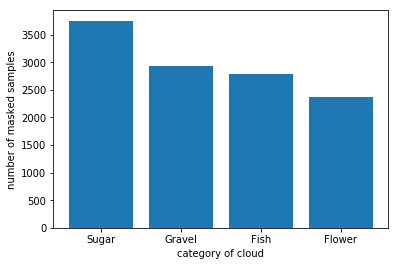

In [5]:
cat=train[train['EncodedPixels'].notnull()]['cat'].value_counts()
plt.bar(cat.index,cat)
plt.xlabel('category of cloud')
plt.ylabel('number of masked samples')
plt.show()

- We can see that the classes are not evenly distributed in the training set.The **sugar** type dominates in the patterns observed.

### Number of masked vs unmasked samples ?

<BarContainer object of 2 artists>

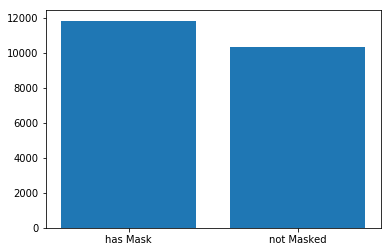

In [6]:
x1=train[train['EncodedPixels'].notnull()].shape[0]
x2=train[train['EncodedPixels'].isnull()].shape[0]
plt.bar(['has Mask','not Masked'],[x1,x2])

### Number of missing masks

In [7]:
train['has_mask']= ~pd.isna(train['EncodedPixels'])
train['missing']= pd.isna(train['EncodedPixels'])

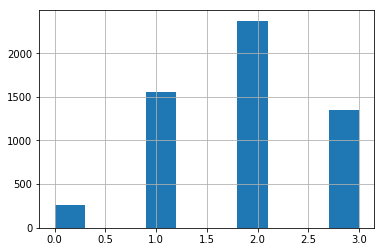

In [8]:
train_nan=train.groupby('ImageId').agg('sum')
train_nan.columns=['No: of Masks','Missing masks']
train_nan['Missing masks'].hist()

mask_count_df=pd.DataFrame(train_nan)



- Here you can see that for  most of the images there are two mask which is available.
- There is no images having all 4 mask as  missing.

### Number of masks per image

In [21]:
mask_count_df = train.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('has_mask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 3)


,ImageId,has_mask,missing
821,24dd99c.jpg,4.0,0.0
1885,562f80a.jpg,4.0,0.0
3260,944f10b.jpg,4.0,0.0
1872,55b539f.jpg,4.0,0.0
4464,cdf7242.jpg,4.0,0.0


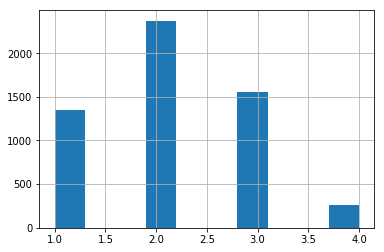

In [22]:
train_nan['No: of Masks'].hist()

- For mojority of the  images there are 2 masks.
- There are only less than 250 images having all 4 masks present in it.

### What are the sizes of images

In [23]:
image_size=defaultdict(int)
image_file=path/'train_images'
for img in image_file.iterdir():
    img=Image.open(img)
    image_size[img.size]+=1

    

In [24]:
image_size

defaultdict(int, {(2100, 1400): 5546})

- All images are of the same 2100 * 1400.
- There are 5546 distinct images in the training set.

In [25]:
image_size=defaultdict(int)
image_file=path/'test_images'
for img in image_file.iterdir():
    img=Image.open(img)
    image_size[img.size]+=1
    

In [26]:
image_size

defaultdict(int, {(2100, 1400): 3698})

- All images are of the same 2100 * 1400.
- There are 3698 distinct images in the test set.

### What are the number of images with no masks ?

In [11]:
no_patterns=0
patterns=0

for i in range(0,len(train),4):
    samples=[x.split('_')[0] for x in train.iloc[i:i+4,0].values]
    if(samples[0]!=samples[1]!=samples[2]!=samples[3]):
        raise ValueError
    labels=train.iloc[i:i+4]['EncodedPixels']
    if labels.isna().all():
        no_patterns+=1
    else:
        patterns+=1
        
    

In [12]:
print('Number of images with patterns {} '.format(patterns))
print("Number of images without patterns {} ".format(no_patterns))


Number of images with patterns 5546 
Number of images without patterns 0 


In [13]:
labels = sorted(list(set(train['Image_Label'].apply(lambda x: x.split('_')[1]))))
print(labels)

['Fish', 'Flower', 'Gravel', 'Sugar']


## Utility function

In [14]:
def rle_decode(mask,shape=(1400,2100)):
    
    s=mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts-=1
    end=starts+lengths
    img=np.zeros(shape[0]*shape[1],dtype=np.uint8)
    for l,m in zip(starts,end):
        img[l:m]=1
    return img.reshape(shape[0],shape[1],order='F')


    

In [15]:
train_nan[train_nan['No: of Masks']==4].iloc[0]

No: of Masks     4.0
Missing masks    0.0
Name: 00dec6a.jpg, dtype: float64

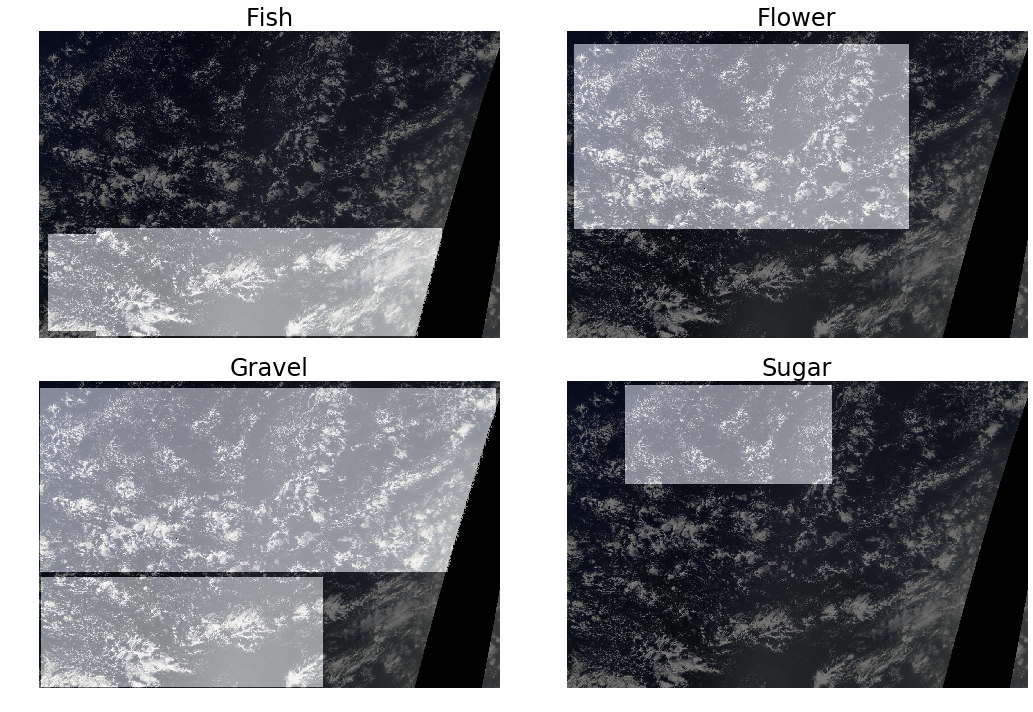

In [16]:
image_name = '00dec6a.jpg'
img = imread(str(path)+'/train_images/' + image_name)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for e, label in enumerate(labels):
    axarr = ax.flat[e]
    image_label = image_name + '_' + label
    mask_rle = train.loc[train['Image_Label'] == image_label, 'EncodedPixels'].values[0]
    try: # label might not be there!
        mask = rle_decode(mask_rle)
    except:
        mask = np.zeros((1400, 2100))
    axarr.axis('off')
    axarr.imshow(img)
    axarr.imshow(mask, alpha=0.5, cmap='gray')
    axarr.set_title(label, fontsize=24)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
> Unhide the below code to see the function

In [ ]:
# create dummy columns for each cloud type
corr_df = pd.get_dummies(train, columns = ['Label'])
# fill null values with '-1'
corr_df = corr_df.fillna('-1')

# define a helper function to fill dummy columns
def get_dummy_value(row, cloud_type):
    ''' Get value for dummy column '''
    mask_rle = row['EncodedPixels'].values[0]
    try: # label might not be there!
        mask = rle_decode(mask_rle)
    except:
        mask = np.zeros((1400, 2100))
    if cloud_type == 'fish':
        return row['Label_Fish'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'flower':
        return row['Label_Flower'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'gravel':
        return row['Label_Gravel'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'sugar':
        return row['Label_Sugar'] * (row['EncodedPixels'] != '-1')
    
# fill dummy columns
corr_df['Label_Fish'] = corr_df.apply(lambda row: get_dummy_value(row, 'fish'), axis=1)
corr_df['Label_Flower'] = corr_df.apply(lambda row: get_dummy_value(row, 'flower'), axis=1)
corr_df['Label_Gravel'] = corr_df.apply(lambda row: get_dummy_value(row, 'gravel'), axis=1)
corr_df['Label_Sugar'] = corr_df.apply(lambda row: get_dummy_value(row, 'sugar'), axis=1)

# check the result
corr_df.head()

# group by the image
corr_df = corr_df.groupby('Image')['Label_Fish', 'Label_Flower', 'Label_Gravel', 'Label_Sugar'].max()
corr_df.head()

#Find out correlation between columns and plot
corrs = np.corrcoef(corr_df.values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar'], 
               xticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar']).set_title('Cloud type correlation heatmap')

fig = hm.get_figure()

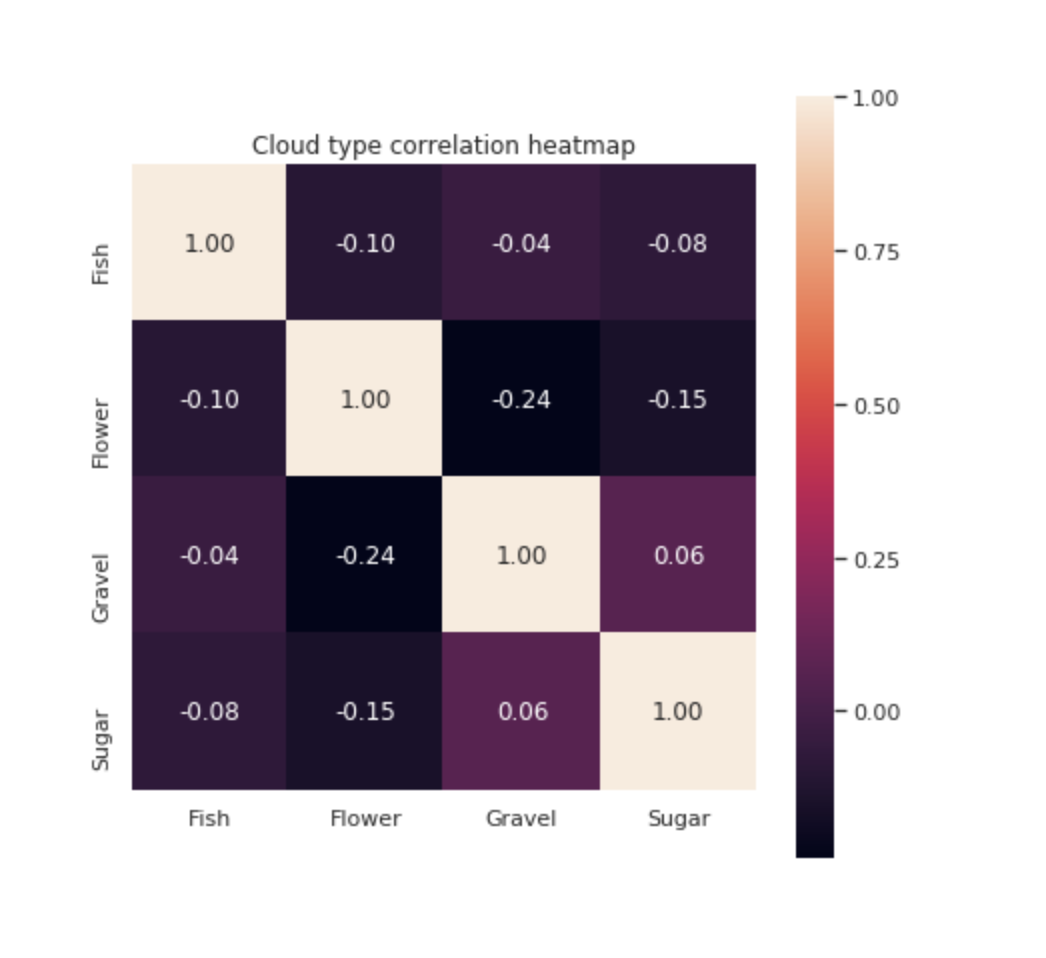

In [ ]:
def plot_training_images_and_masks(n_images = 3):
    '''
    Function to plot several random images with segmentation masks.
    INPUT:
        n_images - number of images to visualize
    '''
    
    # get a list of images from training set
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, ax = plt.subplots(n_images, 4, figsize=(20, 10))
    
    # create a list of random indices 
    rnd_indices = [np.random.choice(range(0, len(images))) for i in range(n_images)]
    
    for im in range(0, n_images):
        # open image with a random index
        image = Image.open(images[rnd_indices[im]])
        
        # get segmentation masks
        fish = get_mask_by_image_id(images[rnd_indices[im]], 'Fish')
        flower = get_mask_by_image_id(images[rnd_indices[im]], 'Flower')
        gravel = get_mask_by_image_id(images[rnd_indices[im]], 'Gravel')
        sugar = get_mask_by_image_id(images[rnd_indices[im]], 'Sugar')
        
        # draw masks on images
        shape = (np.asarray(image).shape[0], np.asarray(image).shape[1])
        if np.sum(fish) > 0:
            segmap_fish = SegmentationMapOnImage(fish, shape=shape, nb_classes=2)
            im_fish = np.array(segmap_fish.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_fish = np.asarray(image)
        
        if np.sum(flower) > 0:
            segmap_flower = SegmentationMapOnImage(flower, shape=shape, nb_classes=2)
            im_flower = np.array(segmap_flower.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_flower = np.asarray(image)
        
        if np.sum(gravel) > 0:
            segmap_gravel = SegmentationMapOnImage(gravel, shape=shape, nb_classes=2)
            im_gravel = np.array(segmap_gravel.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_gravel = np.asarray(image)
        
        if np.sum(sugar) > 0:
            segmap_sugar = SegmentationMapOnImage(sugar, shape=shape, nb_classes=2)
            im_sugar = np.array(segmap_sugar.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_sugar = np.asarray(image)
        
        # plot images and masks
        ax[im, 0].imshow(im_fish)
        ax[im, 0].axis('off')
        ax[im, 0].set_title('Fish')
        
        # plot images and masks
        ax[im, 1].imshow(im_flower)
        ax[im, 1].axis('off')
        ax[im, 1].set_title('Flower')
        
        # plot images and masks
        ax[im, 2].imshow(im_gravel)
        ax[im, 2].axis('off')
        ax[im, 2].set_title('Gravel')
        
        # plot images and masks
        ax[im, 3].imshow(im_sugar)
        ax[im, 3].axis('off')
        ax[im, 3].set_title('Sugar')
        
    plt.show()
    
# function to plot a grid of images and their labels and segmantation maps
def plot_training_images_and_masks(width = 2, height = 3):
    """
    Function to plot grid with several examples of cloud images from train set.
    INPUT:
        width - number of images per row
        height - number of rows

    OUTPUT: None
    """
    
    # get a list of images from training set
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, axs = plt.subplots(height, width, figsize=(20, 20))
    
    # create a list of random indices 
    rnd_indices = rnd_indices = [np.random.choice(range(0, len(images))) for i in range(height * width)]
    
    for im in range(0, height * width):
        # open image with a random index
        image = Image.open(images[rnd_indices[im]])
        # draw segmentation maps and labels on image
        image = draw_segmentation_maps(images[rnd_indices[im]])
        
        i = im // width
        j = im % width
        
        # plot the image
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(get_labels(images[rnd_indices[im]].split('/')[-1]))

    # set suptitle
    plt.suptitle('Sample images from the train set')
    plt.show()    
    
np.random.seed(42)
plot_training_images_and_masks()

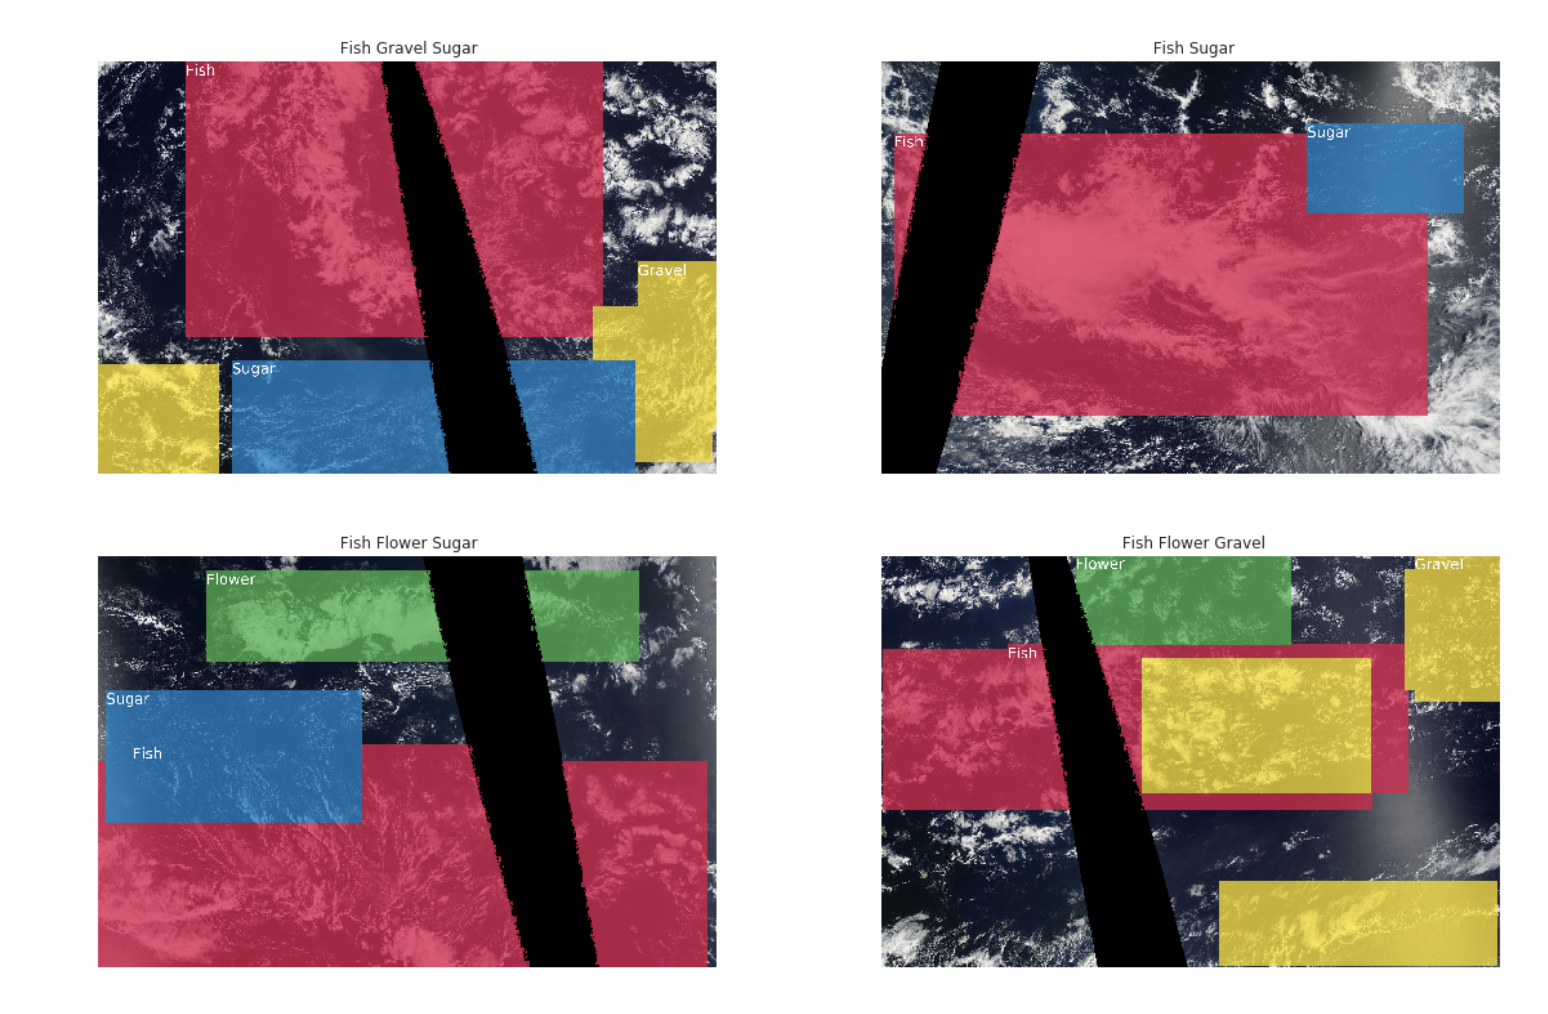

In [33]:


def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

## Data Generator

In order to train your model, you will ideally need to generate batches of images to feed it. While you do this, you may want to perform common operations across all these images — Operations like rescaling, rotations, crops and shifts, etc. This is called data augmentation. In fact, one very common practice is to resize all images to a one shape, to make the training process uniform.

Note that data augmentation does not change your image — It simply creates another representation of the same image. Imagine if someone took a picture of you, and then rotated that picture by some angle. These are two different pictures, but the object of the picture [you] does not change.

To achieve this, we use Keras’s ImageDataGenerator.





We make our Datagenerator class to inherit properties from **keras.utils.sequence** so that we can leverage nice functionalities like multicore processing.This ensures that Datageneration is not an overhead to the system.


We put as arguments relevant information about the data, such as dimension sizes (e.g. a volume of length 32 will have dim=(32,32,32)), number of channels, number of classes, batch size, or decide whether we want to shuffle our data at generation. We also store important information such as labels and the list of IDs that we wish to generate at each pass.

Here, the method **on_epoch_end** is triggered once at the very beginning as well as at the end of each epoch. If the shuffle parameter is set to True, we will get a new order of exploration at each pass (or just keep a linear exploration scheme otherwise).

In [34]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/understanding_cloud_organization/train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 n_classes=4, random_state=2019, shuffle=True, augmentation=None, resized_height=260, resized_width=260):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.augmentation = augmentation
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            
            if self.n_channels == 3:
                img = self.__load_rgb(img_path)
            else:
                img = self.__load_grayscale(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            if len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)
                
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img


Unhide code above to see the DataGenerator class.^

## Metrics to Evaluate your Semantic Segmentation Model

Dice Coefficient (F1 Score)

Simply put, the Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.

![](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png)

If Area of Overlap is 95 
Total pixels is 200

(2 * Area of Overlap)/(total pixels combined) = 95*2/200 = 0.95

Source for bce_dice_loss: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [35]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


Now we will split our data to train and  validation data,so as to train and validate our model before submitting it to the competition.
We will define a BATCH_SIZE of 32,to make the model 32 samples per iteration.

In [36]:
BATCH_SIZE = 32
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train,
    batch_size=BATCH_SIZE,
    reshape=(256, 384),
    n_channels=3,
    n_classes=4,
    augmentation=albumentations_train
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train,
    batch_size=BATCH_SIZE, 
    reshape=(256, 384),
    n_channels=3,
    n_classes=4
)

## Download UNET

In [37]:
! pip install segmentation-models

You should consider upgrading via the 'pip install --upgrade pip' command.


![](https://raw.githubusercontent.com/qubvel/segmentation_models/master/images/logo.png)

Segmentation models is python library with Neural Networks for Image Segmentation based on Keras and Tensorflow Keras frameworks.

The main features of this library are:

-    High level API (just two lines of code to create model for segmentation)
-    4 models architectures for binary and multi-class image segmentation (including legendary Unet)
-    25 available backbones for each architecture
-    All backbones have pre-trained weights for faster and better convergence
-    Helpful segmentation losses (Jaccard, Dice, Focal) and metrics (IoU, F-score)


In [38]:
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing

# LOAD UNET WITH PRETRAINING FROM IMAGENET
#preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
model = Unet('resnet34', input_shape=(256, 384, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])


Segmentation Models: using `keras` framework.
85524480/85521592 [==============================] - 1s 0us/step


### Model Summary

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 384, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 384, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 390, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 192, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

## Fit Generator

Now we will make use of the fit_generator() method to fit our data.We will only run 5 epochs.You can change it fit your requirements.

In [41]:
history=model.fit_generator(train_generator,validation_data=val_generator,epochs=10,verbose=3)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
import efficientnet.keras as efn 
from keras.layers import Dense, Flatten
from keras.models import Model, load_model

def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB2(weights='imagenet', include_top=False, pooling='avg', input_shape=(260, 260, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

for base_layer in model.layers[:-3]:
    base_layer.trainable = False
    
model.compile(optimizer='adam',  loss='categorical_crossentropy', metrics=[dice_coef])
history_0 = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs=10,
                              verbose=3
                             )

## Evaluating our model

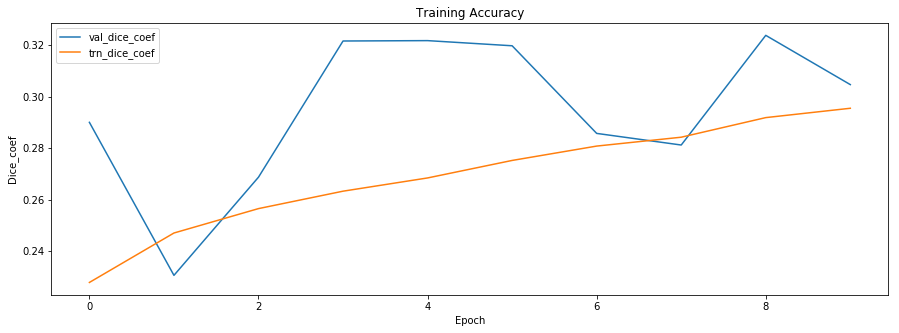

In [42]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()
